In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

----
### Step 1: load datasets

- dict_muni_pop(not used): population of each municipality
- coordinates_book(used): the center of population of each municipality
- out_commuters_book(used): number of out-commuters of each municipality
- workers_by_home_municipality_book(used): number of workers living in each municipality
- jobs_in_each_municipality_book(used): number of jobs located in each municipality
- tessellation(used): spatial information of each municipality, for calculating the average area $<S>$

In [2]:
def weighted_average(value_list, weight_list):
    result = sum([value_list[i]*weight_list[i] for i in range(len(value_list))])/sum(weight_list)
    return result

def read_population_data_and_sum_in_municipality_level(datapath, separator, text_encoding_format, number_of_coloumns, measure_coloumn):
    ### aim: read the zipcode level data downloaded from statistics Finalnd and return population and average coordinate of each municipality 
    #data heading is: 
#"Postal code area","X coordinate in metres","Y coordinate in metres","Surface area","Inhabitants, total, 2018 (HE)","Males, 2018 (HE)","Females, 2018 (HE)","Average age of inhabitants, 2018 (HE)","0-2 years, 2018 (HE)","3-6 years, 2018 (HE)","7-12 years, 2018 (HE)","13-15 years, 2018 (HE)","16-17 years, 2018 (HE)","18-19 years, 2018 (HE)","20-24 years, 2018 (HE)","25-29 years, 2018 (HE)","30-34 years, 2018 (HE)","35-39 years, 2018 (HE)","40-44 years, 2018 (HE)","45-49 years, 2018 (HE)","50-54 years, 2018 (HE)","55-59 years, 2018 (HE)","60-64 years, 2018 (HE)","65-69 years, 2018 (HE)","70-74 years, 2018 (HE)","75-79 years, 2018 (HE)","80-84 years, 2018 (HE)","85 years or over, 2018 (HE)","Aged 18 or over, total, 2018 (KO)"
    #an example line from data:
    #00130 Kaartinkaupunki (Helsinki),386244,6671474,428960,1523,735,788,41,41,47,63,29,24,26,98,160,139,122,116,103,120,101,79,79,88,47,26,15,1319
    line_counter = 0
    municipality_info_book = {}
    municipality_pop_book = {}
    municipality_coordinates_book = {}
    with open(data_path, 'r', encoding=text_encoding_format) as data:
        for line in data:
            line_counter += 1
            if line_counter > 4:
                fields = line.strip().split(separator)
                if len(fields) == number_of_coloumns:
                    area_name_string = fields[0]
                    municipality = area_name_string.strip().split(' ')[-1]
                    x_coordinate = int(fields[1])
                    y_coordinate = int(fields[2])
                    population = int(fields[measure_coloumn])
                    if municipality not in municipality_info_book.keys():
                        municipality_info_book[municipality] = []
                    municipality_info_book[municipality].append((population, x_coordinate, y_coordinate))
                #from IPython.core.debugger import Pdb
                #Pdb().set_trace()  
        for municipality in municipality_info_book.keys():
            #calculate the population sum in each municipality an coordinates of population center (weighted average of 
            pop_list, x_list, y_list = zip(*municipality_info_book[municipality])
            pop_sum = sum(pop_list)
            x_avg = weighted_average(x_list, pop_list)
            y_avg = weighted_average(y_list, pop_list)
            municipality_pop_book[municipality] = pop_sum
            municipality_coordinates_book[municipality] = (x_avg, y_avg)        
    return municipality_pop_book, municipality_coordinates_book


def read_commutters_data(data_path, text_encoding_format, number_of_header_lines,
                        number_of_coloumns, measure_coloumn):
    measure_book = {}
    line_counter = 0
    with open(data_path, 'r', encoding=text_encoding_format) as data:
        for line in data:
            line_counter += 1
            if line_counter > number_of_header_lines:
                #from IPython.core.debugger import Pdb
                #Pdb().set_trace()
                fields = line.strip().split(';')
                assert len(fields) == number_of_coloumns
                city = fields[0]
                measure = int(fields[measure_coloumn])
                measure_book[city] = measure
    return measure_book

In [3]:
### Reading the data and extracting poulation to calculate the center of population of each municipality
data_path = "./data/population_data/population_2017_cleaned.csv"
## this function can be used to extrct population and coordinates info for "municipalities". In that case, population is sum of all the zipcode regions in the municipality and x ant y coordinate are coordinates of center of population of the municipality (weighted average)
dict_muni_pop, coordinates_book = read_population_data_and_sum_in_municipality_level(data_path, ';', 'iso-8859-1', 5, 3) #notice that in the population data there is a municipality named "Valtimo" which can not be found in communting data 

In [4]:
### Reading the data from statistics Finland on number of out-commuters of each municipality, "ni+" in Lasse's notation
out_commutters_data_path = "./data/population_data/out_degree_cleaned.csv"
out_commuters_book = read_commutters_data(out_commutters_data_path, 'iso-8859-1', 4, 12, 3)

### Reading the data from statistics Finland on total number of workers living in each municipality, "ni:" in Lasse's notation
num_workers_by_home_municipality_data_path = "./data/population_data/num_employed_by_home_municipality_cleaned.csv"
workers_by_home_municipality_book = read_commutters_data(num_workers_by_home_municipality_data_path, 'iso-8859-1', 3, 11, 2)

### Reading the data from statistics Finland on total number of jobs located in each municipality, "n:i" in Lasse's notation
num_jobs_in_each_muncipality_data_path = "./data/population_data/num_jobs_in_each_municipality_cleaned.csv"
jobs_in_each_municipality_book = read_commutters_data(num_jobs_in_each_muncipality_data_path, 'iso-8859-1', 3, 11, 2)

In [5]:
df_muni_pop = pd.DataFrame(dict_muni_pop.items(), columns=['name', 'population'])
df_out_commuters_book = pd.DataFrame(out_commuters_book.items(), columns=['name', 'out_degree'])
df_workers_by_home_municipality_book = pd.DataFrame(workers_by_home_municipality_book.items(), columns=['name', 'workers'])
df_jobs_in_each_municipality_book = pd.DataFrame(jobs_in_each_municipality_book.items(), columns=['name', 'jobs'])

In [6]:
df = df_muni_pop.merge(df_out_commuters_book, on='name', how='outer')
df = df.merge(df_workers_by_home_municipality_book, on='name', how='outer')
df = df.merge(df_jobs_in_each_municipality_book, on='name', how='outer')

In [7]:
df

,name,population,out_degree,workers,jobs
0,Helsinki,628556.0,70820,309685,397346
1,Sipoo,18957.0,6864,9813,6415
2,Porvoo,49950.0,8043,22375,21265
3,Vantaa,219502.0,57801,106531,116320
4,Nurmijärvi,41199.0,12898,19654,12195
...,...,...,...,...,...
306,Savukoski,973.0,104,369,334
307,Enontekiö,1802.0,166,725,646
308,Inari,6643.0,378,2994,3010
309,Utsjoki,1217.0,84,486,473


In [8]:
tessellation = gpd.read_file('./data/finland-municipalities-topojson.geojson').rename(columns={'id': 'tile_ID'})

dict_change_name = {
    'Inkoo':'Ingå',
    'Koski Tl':'Koski_Tl',
    'Kristiinankaupunki':'Kristinestad',
    'Kruunupyy':'Kronoby',
    'Luoto':'Larsmo',
    'Maalahti':'Malax',
    'Maarianhamina':'Mariehamn',
    'Mustasaari':'Korsholm',
    'Närpiö':'Närpes',
    'Pietarsaari':'Jakobstad',
    'Pedersören kunta':'Pedersöre',
    'Uusikaarlepyy':'Nykarleby',
    'Kemiönsaari':'Kimitoön',
    'Parainen':'Pargas'
}

tessellation['name'].replace(dict_change_name, inplace=True)

In [9]:
tessellation = tessellation.merge(df, on='name', how='outer')

In [10]:
print(tessellation[tessellation['population'].isna()])

# https://ugeo.urbistat.com/AdminStat/en/fi/demografia/dati-sintesi/valtimo/20505242/4
# fill the population of Valtimo
tessellation.fillna(2218, inplace=True)

print(tessellation[tessellation['population'].isna()])

    tile_ID code     name                                           geometry  \
281     911  911  Valtimo  MULTIPOLYGON (((29.11173 63.84641, 29.12750 63...   

     population  out_degree  workers  jobs  
281         NaN         268      718   585  
Empty GeoDataFrame
Columns: [tile_ID, code, name, geometry, population, out_degree, workers, jobs]
Index: []


In [11]:
dict_tile_name = dict(zip(tessellation.tile_ID, tessellation.name))

In [12]:
print(tessellation[tessellation['jobs'].isna()])

Empty GeoDataFrame
Columns: [tile_ID, code, name, geometry, population, out_degree, workers, jobs]
Index: []


----
### parameter calibration based on the average unit surface

In [13]:
# epsg:3067 ETRS89 / TM35FIN(E,N)

muni_pcrs = tessellation.to_crs(3067)
muni_pcrs['centroid'] = muni_pcrs.geometry.centroid
muni_pcrs['area'] = muni_pcrs.area / 10**6
print('total area: %.3f km2, avg. area: %.3f km2' % (muni_pcrs['area'].sum(), muni_pcrs['area'].mean()))

total area: 336195.870 km2, avg. area: 1081.016 km2


In [14]:
coordinates_book['Valtimo'] = muni_pcrs[muni_pcrs.name == 'Valtimo'].centroid.geometry.values[0].coords[0]

<AxesSubplot:>

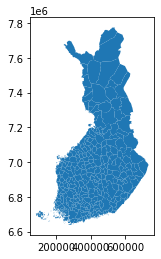

In [15]:
muni_pcrs.plot()

In [16]:
beta = 0.3 * muni_pcrs['area'].mean() ** -0.18
beta

0.08531619877853533

In [33]:
def gravity_exp(df, beta):
    
    def cal_distance(p1, p2):
        x1, y1 = coordinates_book[p1]
        x2, y2 = coordinates_book[p2]
        return np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2) / 1000 # km

    od = []
    
    for i in range(len(df)):
        for j in range(i + 1, len(df)):

            dist = cal_distance(df.iloc[i]['name'], df.iloc[j]['name'])
                
            flow = df.iloc[i].workers * df.iloc[j].jobs * np.exp(-beta * dist)
            od.append([df.iloc[i].code, df.iloc[j].code, flow])

            flow = df.iloc[j].workers * df.iloc[i].jobs * np.exp(-beta * dist)
            od.append([df.iloc[j].code, df.iloc[i].code, flow])

    return od

In [36]:
%%time
fraction = gravity_exp(muni_pcrs, beta)

CPU times: user 1min 5s, sys: 56.7 ms, total: 1min 5s
Wall time: 2min 11s


In [37]:
df_gravity_exp_fraction = pd.DataFrame(fraction, columns=['origin', 'destination', 'fraction'])

In [38]:
df_gravity_exp_fraction['fraction'].sum(), beta

(99270906637.37334, 0.08531619877853533)

----
# Production constrained, resample according to out-degree

In [44]:
trips = []
for index, row in tessellation.iterrows():
    
    k = row.out_degree
    origin = row.tile_ID
    
    select = df_gravity_exp_fraction[df_gravity_exp_fraction['origin'] == origin].copy(True)
    select['weight'] = select['fraction'] / select['fraction'].sum()
    select['flow'] = select['weight'] * k
    
    trips.append(select)

In [45]:
df_od = pd.concat(trips)

In [48]:
df_od['origin'] = df_od['origin'].map(dict_tile_name)
df_od['destination'] = df_od['destination'].map(dict_tile_name)

In [67]:
df_od['filtered_flow'] = df_od.flow.apply(lambda z: z if z >= 5 else 0)

In [69]:
df_od['flow'].sum(), df_od['filtered_flow'].sum(), tessellation['out_degree'].sum()

(805713.0000000001, 797838.3124380806, 805713)

In [70]:
df_od.head(20)

,origin,destination,fraction,weight,flow,filtered_flow
0,Alajärvi,Alavieska,3.385143e+01,8.690358e-06,7.212997e-03,0.000000
2,Alajärvi,Alavus,1.843827e+05,4.733483e-02,3.928791e+01,39.287911
4,Alajärvi,Asikkala,5.446030e-02,1.398108e-08,1.160429e-05,0.000000
6,Alajärvi,Askola,8.448102e-05,2.168801e-11,1.800105e-08,0.000000
8,Alajärvi,Aura,2.666951e-04,6.846611e-11,5.682687e-08,0.000000
10,Alajärvi,Brändö,3.258724e-07,8.365814e-14,6.943625e-11,0.000000
12,Alajärvi,Eckerö,4.582832e-09,1.176507e-15,9.765010e-13,0.000000
14,Alajärvi,Enonkoski,7.632208e-05,1.959345e-11,1.626256e-08,0.000000
16,Alajärvi,Enontekiö,3.956517e-17,1.015719e-23,8.430470e-21,0.000000
18,Alajärvi,Espoo,7.815635e-04,2.006434e-10,1.665340e-07,0.000000


In [71]:
df_od.to_csv('results/gravity_model_exp_avg_surface_with_commuter.csv', index=False)

----

In [72]:
from shapely.geometry import Point

In [73]:
df_pop_center = pd.DataFrame([[k, Point(v)] for k, v in coordinates_book.items()], 
                             columns=['name', 'geometry'])

gdf_pop_center = gpd.GeoDataFrame(df_pop_center, geometry='geometry')

In [74]:
gdf_centroid = gpd.GeoDataFrame(muni_pcrs[['tile_ID', 'name', 'centroid']], geometry='centroid')

<AxesSubplot:>

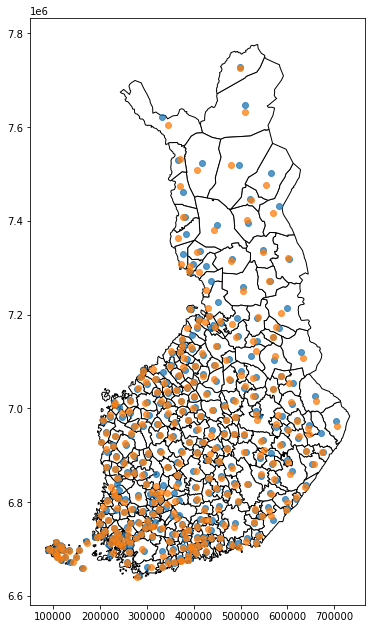

In [75]:
ax = muni_pcrs.plot(figsize=(6, 14), fc='white', ec='k')
gdf_centroid.plot(ax=ax, color='C0', alpha=0.75)
gdf_pop_center.plot(ax=ax, color='C1', alpha=0.75)

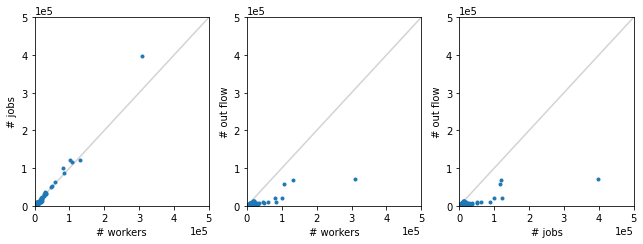

In [76]:
plt.figure(figsize=(9, 3.5))
plt.subplot(1, 3, 1)
plt.plot([0, 5e5], [0, 5e5], color='lightgrey', ls='-')
plt.plot(df.workers, df.jobs, '.')
plt.xlim([0, 5e5])
plt.ylim([0, 5e5])
plt.ticklabel_format(style='sci', axis='both', scilimits=(1,3))
plt.xlabel('# workers')
plt.ylabel('# jobs')

plt.subplot(1, 3, 2)
plt.plot([0, 5e5], [0, 5e5], color='lightgrey', ls='-')
plt.plot(df.workers, df.out_degree, '.')
plt.xlim([0, 5e5])
plt.ylim([0, 5e5])
plt.ticklabel_format(style='sci', axis='both', scilimits=(1,3))
plt.xlabel('# workers')
plt.ylabel('# out flow')

plt.subplot(1, 3, 3)
plt.plot([0, 5e5], [0, 5e5], color='lightgrey', ls='-')
plt.plot(df.jobs, df.out_degree, '.')
plt.xlim([0, 5e5])
plt.ylim([0, 5e5])
plt.ticklabel_format(style='sci', axis='both', scilimits=(1,3))
plt.xlabel('# jobs')
plt.ylabel('# out flow')

plt.tight_layout()

----
# compare gravity to radiation

In [77]:
df_gravity = pd.read_csv('results/gravity_model_exp_avg_surface_with_commuter.csv')
df_radiation = pd.read_csv('results/radiation_model_number_of_commuters_as_prior.csv')

In [88]:
df_merge = df_gravity[['origin', 'destination', 'flow']].merge(df_radiation[['origin', 'destination', 'estimated_population_flow']],
                            on=['origin', 'destination'], how='outer')

In [89]:
df_merge.fillna(0, inplace=True)

In [90]:
df_merge.columns = ['origin', 'destination', 'gravity', 'radiation']

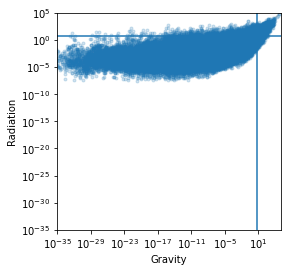

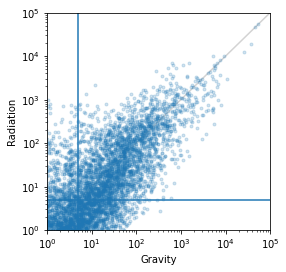

In [94]:
plt.figure(figsize=(4, 4))
plt.plot([5, 1e5], [5, 1e5], '-', color='lightgrey')
plt.loglog(df_merge.gravity, df_merge.radiation, '.', alpha=0.2)
plt.xlabel('Gravity')
plt.ylabel('Radiation')
plt.xlim([1e-35, 1e5])
plt.ylim([1e-35, 1e5])
plt.axhline(5, ls='-')
plt.axvline(5, ls='-')

plt.figure(figsize=(4, 4))
plt.plot([5, 1e5], [5, 1e5], '-', color='lightgrey')
plt.loglog(df_merge.gravity, df_merge.radiation, '.', alpha=0.2)
plt.xlabel('Gravity')
plt.ylabel('Radiation')
plt.xlim([1, 1e5])
plt.ylim([1, 1e5])
plt.axhline(5, ls='-')
plt.axvline(5, ls='-')